In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA
import pandas as pd

In [2]:
import pandas as pd
import gmplot as gp
from matplotlib.colors import to_hex

In [3]:
df_unique = pd.read_csv('df_unique.csv')

In [4]:
bh_interpolated = np.load('bh_observations.npy').transpose()

In [5]:
layer_std = np.std(bh_interpolated, axis=0)

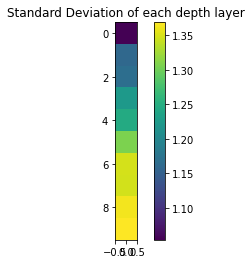

In [6]:
plt.imshow(np.expand_dims(layer_std, axis=1))
plt.colorbar()
plt.title("Standard Deviation of each depth layer")
plt.show()

In [7]:
def flatten_list(L):
    return [item for sublist in L for item in sublist]

In [8]:
def toRadians(degree):
    one_deg =  np.pi / 180
    return one_deg * degree
 
def distance(lat1, long1, lat2, long2):
    
    lat1 = toRadians(lat1);
    long1 = toRadians(long1);
    lat2 = toRadians(lat2);
    long2 = toRadians(long2);
    
    dlong = long2 - long1;
    dlat = lat2 - lat1;
 
    ans = np.square(np.sin(dlat / 2)) + np.cos(lat1) * np.cos(lat2) *np.square(np.sin(dlong / 2))
 
    ans = 2 * np.arcsin(np.sqrt(ans))
    
#     Kilometers, R = 6371
#     Use R = 3956 for miles
    R = 6371000
    
    ans = ans * R
 
    return ans

In [9]:
n_bh = len(df_unique)

In [10]:
lats = df_unique.latitude
longs = df_unique.longitude

In [11]:
bh_interpolated.shape

(561, 10)

In [12]:
distances= []
variance_weighted = []
#for i, bh in df_unique.iterrows():
for i in range(n_bh-1):
    lat1 = lats[i]
    long1 = longs[i]
    
    bh1 = bh_interpolated[i]
    

    lat2 = lats[i+1:n_bh]
    long2 = longs[i+1: n_bh]
    bh2 = bh_interpolated[i+1:n_bh]
    
    cur_distances = distance(lat1, long1, lat2, long2)
    cur_variances = np.linalg.norm(bh2 - bh1, axis=1)
    
    cur_distances[cur_distances == 0] = 1e-12
    #print(cur_distances.shape)
    #print(cur_variances.shape)
    
    scaled_variances = cur_variances / cur_distances
    
    #print(scaled_variances.shape)
    
    distances.append(sorted(list(cur_distances)))
    variance_weighted.append(sorted(list(scaled_variances), reverse=True))
    
#     for j in range(i+1, n_bh):
#         bh2 = df_unique.iloc[[j]]
#         lat2 = np.array(bh2['latitude'])
#         long2 = np.array(bh2['longitude'])
#         distances[i,j] = distance(lat1, long1, lat2, long2)


In [13]:
distances_flat = flatten_list(distances)

In [60]:
len(distances_flat)

157080

In [14]:
distances_flat_sorted = sorted(distances_flat)

In [15]:
distances_flat_sorted[0:10]

[1e-12,
 1e-12,
 9.262617721114353,
 11.379863166641998,
 13.916369734505794,
 14.596940626888797,
 15.233139244299483,
 16.584585613049363,
 17.273330897513805,
 17.80396036794228]

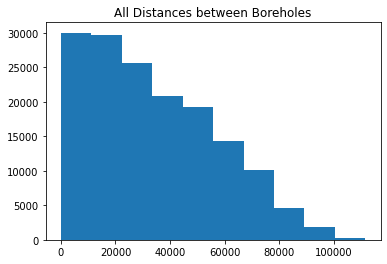

In [16]:
plt.hist(distances_flat)
plt.title("All Distances between Boreholes")
plt.show()

In [17]:
distances_min =  [item[0] for item in distances]

In [62]:
np.mean(distances_min)

746.2753743386546

In [63]:
np.median(distances_min)

136.7429501922902

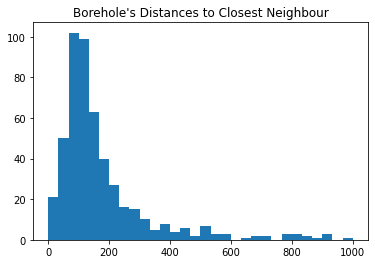

In [18]:
plt.hist(distances_min, bins = 30, range = [0, 1000])
plt.title("Borehole's Distances to Closest Neighbour")
plt.show()

In [19]:
variance_weighted_flat = flatten_list(variance_weighted)

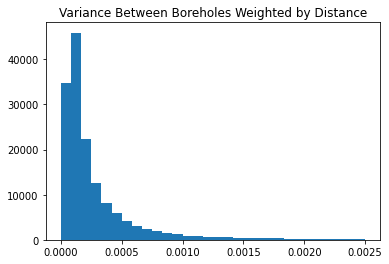

In [20]:
plt.hist(variance_weighted_flat, range=[0, 0.0025], bins=30)
plt.title("Variance Between Boreholes Weighted by Distance")
plt.show()

In [21]:
variance_max = [item[0] for item in variance_weighted]

In [22]:
# greatest variance imaginable is if two boreholes 9 meters apart have profiles all 0 and all 4

np.linalg.norm(np.ones(10) * 4 - np.zeros(10)) / 9.26

1.3659946696191705

In [23]:
np.linalg.norm(np.ones(10) * 1 - np.zeros(10)) / 9.26

0.3414986674047926

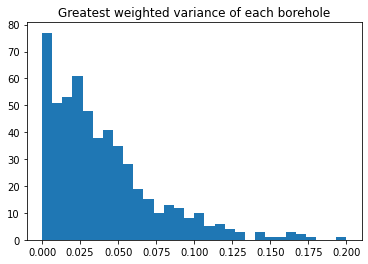

In [24]:
plt.hist(variance_max, bins=30, range=[0, 0.2])
plt.title("Greatest weighted variance of each borehole")
plt.show()

In [25]:
lats = np.array(df_unique.latitude)

In [26]:
lats.sort()

In [27]:
dif = np.diff(lats)

In [28]:
dif.sort()

In [30]:
1.0e-5 * 1110000

11.100000000000001

In [31]:
def plot_gmplot(input, channel=0, map_name='gmap.html', size=50):
    # channel: 0, 1, 2 refers to RGB
    
    df_unique = pd.read_csv('df_unique.csv')
    mean_lat = df_unique.latitude.mean()
    mean_lng = df_unique.longitude.mean()
    
    with open('apikey.txt') as f:
        apikey = f.readlines()[0]

    colour = np.zeros(input.shape)

    for i, c in enumerate(input[:, channel]):
        if c > 0:
            colour[i, channel] = c
        else:
            for k in range(3):
                if k!=channel:
                    colour[i, k] = -c
    
    colour = colour / np.max(colour.flatten())
    colour_hex = [None] * len(colour)

    for i, color in enumerate(colour):
        colour_hex[i] = to_hex(color)
    
    gmap = gp.GoogleMapPlotter(mean_lat, mean_lng, 8, apikey = apikey)
    gmap.scatter(list(df_unique.latitude), list(df_unique.longitude), size = size, color=colour_hex, marker=False) 
    gmap.draw(map_name)
    
    return list(df_unique.latitude), list(df_unique.longitude), colour_hex, colour

In [32]:
n_components = 3

In [33]:
input = np.load('bh_observations.npy')

In [34]:
input.shape

(10, 561)

In [35]:
pca = PCA(n_components=n_components)
pca_sources = pca.fit_transform(input)
pca.explained_variance_ratio_

array([0.46051456, 0.20711781, 0.10397956])

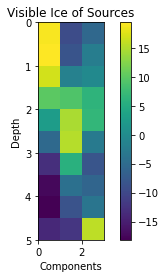

In [36]:
plt.imshow(pca_sources, interpolation = 'none', extent=[0, pca_sources.shape[1], 5, 0])
ax = plt.gca()
ax.set_aspect(2)
plt.colorbar()
plt.title("Visible Ice of Sources")
plt.xlabel("Components")
plt.ylabel('Depth')
# plt.savefig('components_analysis/components_n{}.png'.format(n_components))
plt.show()

In [37]:
pca_h = PCA(n_components=n_components)
pca_h_sources = pca_h.fit_transform(input.T)
pca_h.explained_variance_ratio_

array([0.51903607, 0.21231796, 0.09981609])

In [38]:
pca_h_sources.shape

(561, 3)

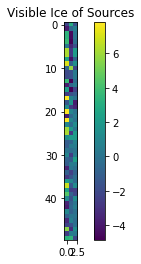

In [39]:
plt.imshow(pca_h_sources[0:50])
plt.title("Visible Ice of Sources")
plt.colorbar()
plt.show()

In [40]:
ica_h = FastICA(n_components=n_components, random_state=0)

ica_h_sources = ica_h.fit_transform(input.T)
mix = ica_h.mixing_

np.save('horizontal_sources_n{}.npy'.format(n_components), ica_h_sources)
np.save('horizontal_mix_n{}.npy'.format(n_components), mix)

In [41]:
ica_h_sources.shape

(561, 3)

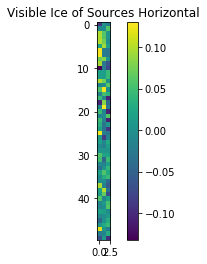

In [42]:
plt.imshow(ica_h_sources[0:50])
plt.title("Visible Ice of Sources Horizontal")
plt.colorbar()
plt.show()

In [43]:
ica_h.mean_.shape

(10,)

In [44]:
channel = 2
lat, lng, colour_hex, colour = plot_gmplot(ica_h_sources[:, 0:3], channel=channel, map_name='ica_h_channel_{}.html'.format(channel))

In [45]:
mix.shape

(10, 3)

In [46]:
np.max(mix, axis=0)

array([ 21.91649423,  16.35216557, -16.7960873 ])

In [47]:
np.min(mix, axis=0)

array([-12.88276843, -14.93057284, -22.73903592])

In [48]:
mix[:,-1] *= -1 

In [52]:
mean = ica_h.mean_
mean = np.expand_dims(mean, axis=1)

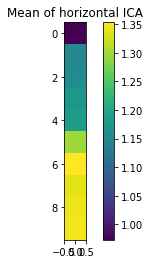

In [54]:
plt.imshow(mean)
plt.colorbar()
plt.title("Mean of horizontal ICA")
plt.show()

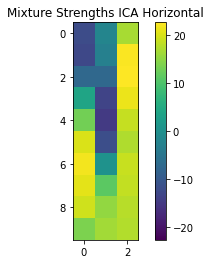

In [55]:
max_val = np.amax(abs(mix))
plt.imshow(mix, vmin = -max_val, vmax=max_val)
plt.title('Mixture Strengths ICA Horizontal')
plt.colorbar()
plt.show()

In [56]:
last_source = ica_h_sources[:, -1]

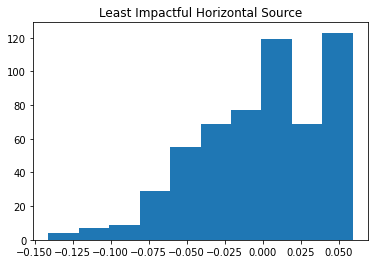

In [57]:
plt.hist(last_source)
plt.title("Least Impactful Horizontal Source")
plt.show()

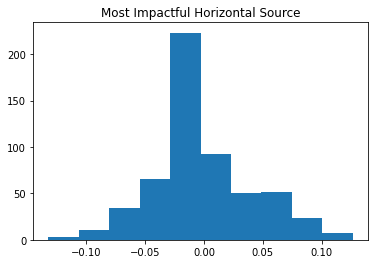

In [58]:
plt.hist(ica_h_sources[:, 0])
plt.title("Most Impactful Horizontal Source")
plt.show()